In [19]:
import numpy as np
import pandas as pd

# Load the feature mapping
data_dir = '../dataset'
feature_mapping_file = f'{data_dir}/meta/idx_to_feature_name.csv'
feature_mapping = pd.read_csv(feature_mapping_file)
print(feature_mapping.head())

# Load an example feature file
example_feature_file = f'{data_dir}/scenes/npy/9_speech_true_Radio_aus.npy'
features = np.load(example_feature_file)
print(f'Feature shape: {features.shape}')
print(features)


   index feature_name
0      0  bandwidth_0
1      1   centroid_0
2      2   contrast_0
3      3   contrast_1
4      4   contrast_2
Feature shape: (175, 503)
[[0.00000000e+00 0.00000000e+00 3.55572597e+03 ... 3.16909110e+03
  3.21029245e+03 3.29810116e+03]
 [0.00000000e+00 0.00000000e+00 2.94330233e+03 ... 2.32232569e+03
  2.16694691e+03 3.32197793e+03]
 [1.06553228e+01 1.06553228e+01 3.97100957e+00 ... 3.03475966e+00
  5.83976492e+00 1.14490307e+00]
 ...
 [0.00000000e+00 0.00000000e+00 5.72300705e-05 ... 1.68575775e-02
  1.34523511e-02 3.48735875e-06]
 [8.00000000e+03 1.00000000e+02 8.00000000e+03 ... 1.01880960e+02
  1.29330128e+02 8.00000000e+03]
 [0.00000000e+00 0.00000000e+00 1.22500000e-01 ... 1.47500000e-01
  9.00000000e-02 2.00000000e-02]]


2024-06-04 13:30:10,004 - INFO - Loading annotations...
2024-06-04 13:30:10,008 - INFO - Annotations loaded.


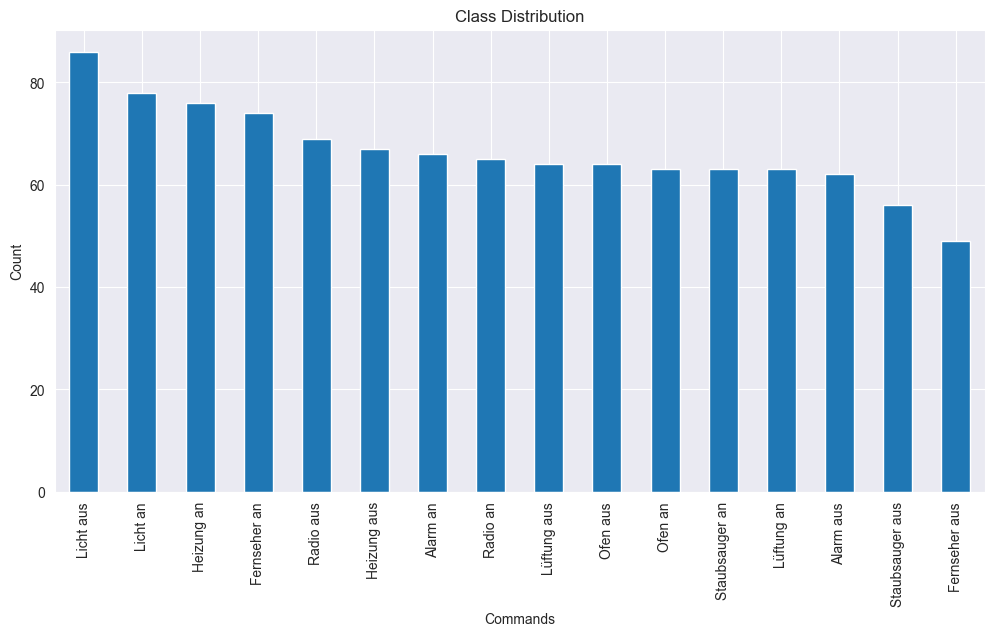

2024-06-04 13:30:10,299 - INFO - Preparing command data...
100%|██████████| 1065/1065 [00:01<00:00, 676.03it/s]
2024-06-04 13:30:13,178 - INFO - Command data prepared.
2024-06-04 13:30:20,249 - INFO - Command mapping: {'Licht aus': 0, 'Ofen an': 1, 'Radio an': 2, 'Fernseher an': 3, 'Heizung aus': 4, 'Alarm an': 5, 'Lüftung aus': 6, 'Staubsauger aus': 7, 'Heizung an': 8, 'Staubsauger an': 9, 'Alarm aus': 10, 'Licht an': 11, 'Ofen aus': 12, 'Radio aus': 13, 'Lüftung an': 14, 'Fernseher aus': 15}
/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-06-04 13:30:20,399 - INFO - Training command recognition model...


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.0655 - loss: 2.8293 - val_accuracy: 0.0751 - val_loss: 2.7675
Epoch 2/50
19/27 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.0768 - loss: 2.7676

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Check class distribution
class_counts = annotations['command'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Commands')
plt.ylabel('Count')
plt.show()

def prepare_feature_data(annotations, data_dir, feature_dir):
    command_features = []
    command_labels = []
    command_mapping = {}  # Mapping of command texts to numerical labels
    current_label = 0
    max_len = 0  # To determine the maximum length of features

    logging.info('Preparing command data...')
    for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0]):
        feature_path = os.path.join(feature_dir, row['filename'] + '.npy')
        features = np.load(feature_path)
        max_len = max(max_len, features.shape[1])  # Update max_len
        
        command_text = row['command']
        if command_text not in command_mapping:
            command_mapping[command_text] = current_label
            current_label += 1
        
        command_label = command_mapping[command_text]
        
        command_features.append(features)
        command_labels.append(command_label)

    # Pad features to the same length
    padded_features = []
    for feature in command_features:
        pad_width = max_len - feature.shape[1]
        if pad_width > 0:
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        padded_features.append(feature)
    
    logging.info('Command data prepared.')
    return np.array(padded_features), np.array(command_labels), command_mapping

# Prepare feature-based command data
feature_dir = f'{data_dir}/scenes/npy'
command_features, command_labels, command_mapping = prepare_feature_data(annotations, data_dir, feature_dir)

# Normalize features
command_features = (command_features - np.mean(command_features, axis=0)) / np.std(command_features, axis=0)

# One-hot encode labels
num_classes = len(command_mapping)
command_labels = to_categorical(command_labels, num_classes=num_classes)

logging.info(f'Command mapping: {command_mapping}')

# Improved model architecture: CNN + LSTM
def build_cnn_lstm_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(input_shape[0], input_shape[1], 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Reshape((input_shape[0] // 4, (input_shape[1] // 4) * 64)),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.5),
        layers.LSTM(128),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (command_features.shape[1], command_features.shape[2])
command_features = command_features.reshape((command_features.shape[0], command_features.shape[1], command_features.shape[2], 1))
command_model = build_cnn_lstm_model(input_shape, num_classes)

logging.info('Training command recognition model...')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_command_model.keras', save_best_only=True, monitor='val_loss')

command_model.fit(command_features, command_labels, epochs=50, batch_size=32, validation_split=0.2,
                  callbacks=[early_stopping, model_checkpoint])
logging.info('Command recognition model trained.')

# Evaluate the model on a new feature file
new_feature_file = f'{feature_dir}/9_speech_true_Radio_aus.npy'
new_features = np.load(new_feature_file)
new_features = np.pad(new_features, ((0, 0), (0, command_features.shape[2] - new_features.shape[1])), mode='constant')
new_features = new_features.reshape(1, new_features.shape[0], new_features.shape[1], 1)
new_features = (new_features - np.mean(command_features, axis=0)) / np.std(command_features, axis=0)

predicted_command = command_model.predict(new_features)
predicted_label = np.argmax(predicted_command)
for command, label in command_mapping.items():
    if label == predicted_label:
        logging.info(f'Predicted command: {command}')
        break
